# Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from matplotlib.gridspec import GridSpec


In [4]:
import os
print(os.getcwd())
file_path = '5D_step4.mat'
print(os.path.abspath(file_path))
print("File exists:", os.path.isfile(file_path))

c:\Users\mauri\OneDrive\Documents\Udem\GPBO_Mau\data\5d_rats_set\new_data
c:\Users\mauri\OneDrive\Documents\Udem\GPBO_Mau\data\5d_rats_set\new_data\5D_step4.mat
File exists: True


In [5]:
data = scipy.io.loadmat('5D_step4.mat')['stim_combinations'] #scipy.io.loadmat(file_path)['Data']
resp = scipy.io.loadmat('5D_step4.mat')['emg_response'] #data[0][0][0]
param = scipy.io.loadmat('5D_step4.mat')['stim_combinations']# data[0][0][1]
ch2xy = param[:32,[-2,-1]].astype(int) -1
resp.shape # nb repetitions x emg channels x nb combinations x emg metric (is a 1x4 array, but only using first 2 indices for peak vs. auc response)

(8, 4, 2048, 4)

In [6]:
peak_resp = resp[:, :, :, 0]
auc_resp = resp[:, :, :, 1]
peak_norm_resp = resp[:, :, :, 2]
auc_norm_resp = resp[:, :, :, 3] 

In [5]:
param.shape # nb combinations x parameters ([PW (us), freq (Hz), stim_train_duration (ms), count, channel, x_ch, y_ch])

(2048, 7)

In [6]:
ch2xy.shape # nb channels x nb spatial dimensions

(32, 2)

In [7]:
np.unique(param[:,0]) #pulse width


array([100.00000149, 200.00000298, 300.00001192, 400.00000596])

In [8]:
np.unique(param[:,1]) #frequency

array([100., 200., 300., 400.])

In [9]:
np.unique(param[:,2]) #stimulation duration

array([ 20.,  40., 100., 200.])

In [10]:
np.unique(param[:,3]) #count

array([ 3.,  5.,  7.,  9., 11., 13., 17., 21., 31., 41., 61., 81.])

In [11]:
np.unique(param[:,4]) #channel number

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32.])

In [12]:
np.unique(param[:,5])

array([1., 2., 3., 4., 5., 6., 7., 8.])

In [89]:
def create_mean_map(resp):

    resp_mu = np.mean(resp,axis=0)
    mean_map = np.zeros((4,4,4,4,8,4))

    for e in range(resp.shape[1]):

        val_pw = np.unique(param[:,0])
        val_freq = np.unique(param[:,1])
        val_duration = np.unique(param[:,2])
        val_pos = np.unique(param[:,4])

        for i in range(len(param)):

            idx_pw = np.where(np.isclose(val_pw, param[i, 0]))[0][0]
            idx_freq = np.where(np.isclose(val_freq, param[i, 1]))[0][0]
            idx_duration = np.where(np.isclose(val_duration, param[i, 2]))[0][0]
            #idx_ch = int(np.where(np.isclose(val_ch,param[i, 4]))[0][0]-1)
            idx_ch = int(param[i, 4]-1)

            x_ch = ch2xy[idx_ch,0]
            y_ch = ch2xy[idx_ch,1]

            mean_map[e, idx_pw, idx_freq, idx_duration, x_ch, y_ch] = resp_mu[e,i]

    return mean_map

# Visualization

In [102]:
emg_channel = 0
other_stim_param_idx = 3

In [106]:
def visualize_heatmaps(map, title):

    channel_19 = (3, 1)
    channel_22 = (3, 6)
    channel_24 = (3, 7)

    channels = (channel_19, channel_22, channel_24)

    responses = []
    for (x, y) in channels:
        responses.append(map[emg_channel, :, :, :, y, x])

    params = [[1, 0], [1, 2], [0,2]]
    axs = [2, 0, 1]
    labels=[['frequency', 'pulse width'], ['frequency', 'stim duration'], ['pulse width', 'stim duration']]

    channel_names = ['channel 19', 'channel 22', 'channel 24']

    # Create a 3x4 grid of subplots
    fig = plt.figure(figsize=(11, 9))
    gs = GridSpec(3, 4, figure=fig, width_ratios=[1, 1, 1, 0.1], wspace=0.5, hspace=0.4)

    # Calculate global min and max for each row
    row_min_max = []
    for i in range(3):  # Rows
        global_min = float('inf')
        global_max = float('-inf')
        for j in range(3):  # Columns
            r = responses[j]
            if i == 0:
                r = r[:, :, other_stim_param_idx]
            elif i == 1:
                r = r[other_stim_param_idx, :, :]
            elif i == 2:
                r = r[:, other_stim_param_idx, :]

            global_min = min(global_min, r.min())
            global_max = max(global_max, r.max())
        
        row_min_max.append((global_min, global_max))

    #gs = GridSpec(4, 3, figure=fig) 

    for i in range(3):  # Rows
        global_min, global_max = row_min_max[i]

        colorbar_ax = fig.add_subplot(gs[i, -1])  # Create the colorbar axis at the end of the row


        for j in range(3):  # Columns
            ax = fig.add_subplot(gs[i, j]) # Access the current subplot

            r = responses[j]
            if i == 0:
                r = r[:, :, other_stim_param_idx]
            elif i == 1:
                r = r[other_stim_param_idx, :, :]
            elif i == 2:
                r = r[:, other_stim_param_idx, :]
            
            #avg_response = np.mean(r, axis=axs[i])

            x = np.round(np.unique(param[:, params[i][0]]))
            y = np.round(np.unique(param[:, params[i][1]]))

            im = ax.imshow(r.T, aspect='auto', cmap='viridis', origin='lower', vmin=global_min, vmax=global_max)
            #ax.colorbar(label='Peak EMG Response')
            ax.set_xlabel(labels[i][0])
            ax.set_ylabel(labels[i][1])
            ax.set_xticks(ticks=np.arange(len(x)), labels=x)
            ax.set_yticks(ticks=np.arange(len(y)), labels=y)
            ax.set_title(channel_names[j])

        fig.colorbar(im, cax=colorbar_ax, orientation='vertical', label=f'{title} (Row {i + 1})')


    # Add a single title for the whole grid
    fig.suptitle(f'{title} for Channel 19, 22 and 24', fontsize=16)

    # Adjust spacing between plots and title
    #fig.colorbar(im, ax=axes, orientation='vertical', label=title, shrink=0.7)

    # Show the plot
    plt.show()



### Peak EMG response

In [107]:
peak_map = create_mean_map(peak_resp)

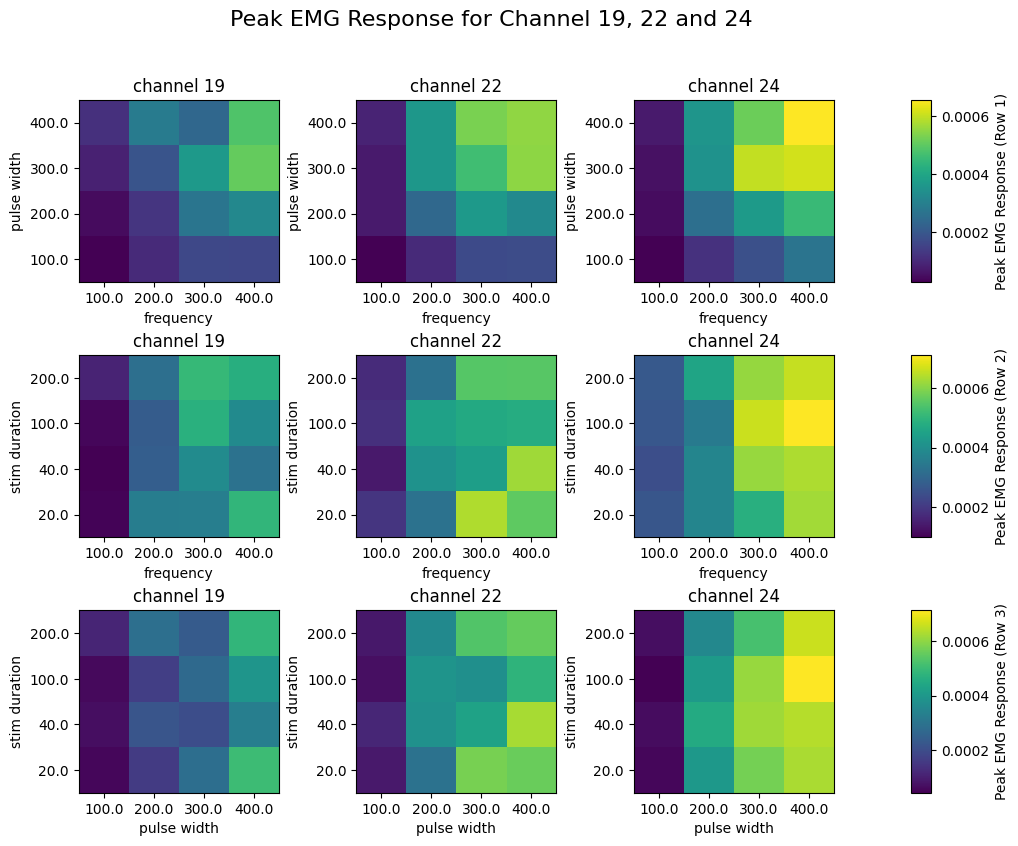

In [108]:
visualize_heatmaps(peak_map, 'Peak EMG Response')

### AUC Emg response

In [12]:
auc_map = create_mean_map(auc_resp)

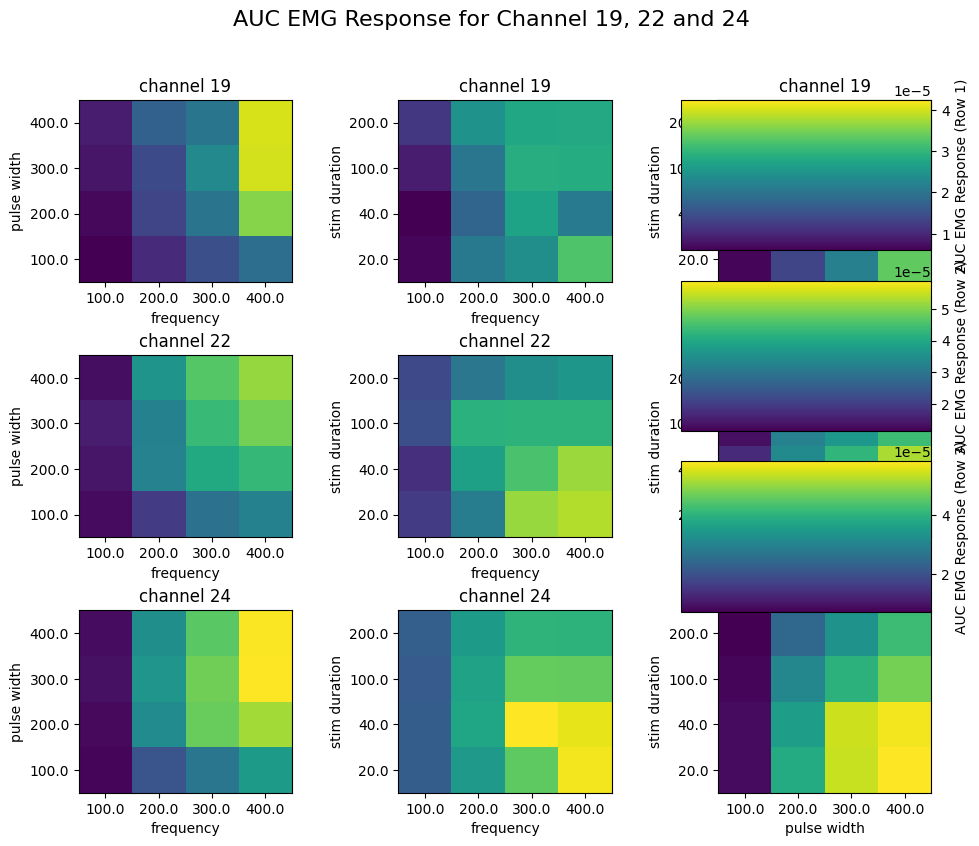

In [13]:
visualize_heatmaps(auc_map, 'AUC EMG Response')

### Peak Normalized EMG response

In [84]:
peak_norm_map = create_mean_map(peak_norm_resp)


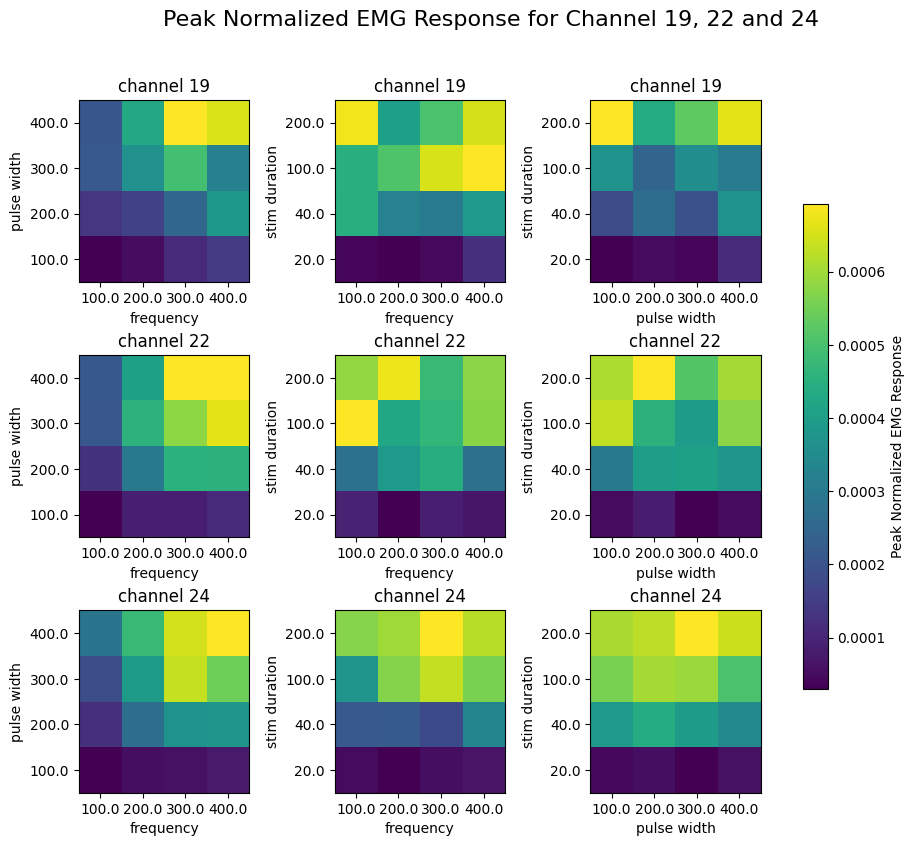

In [111]:
visualize_heatmaps(peak_norm_map, 'Peak Normalized EMG Response')

### AUC normalized EMG response

In [98]:
auc_norm_map = create_mean_map(auc_norm_resp)

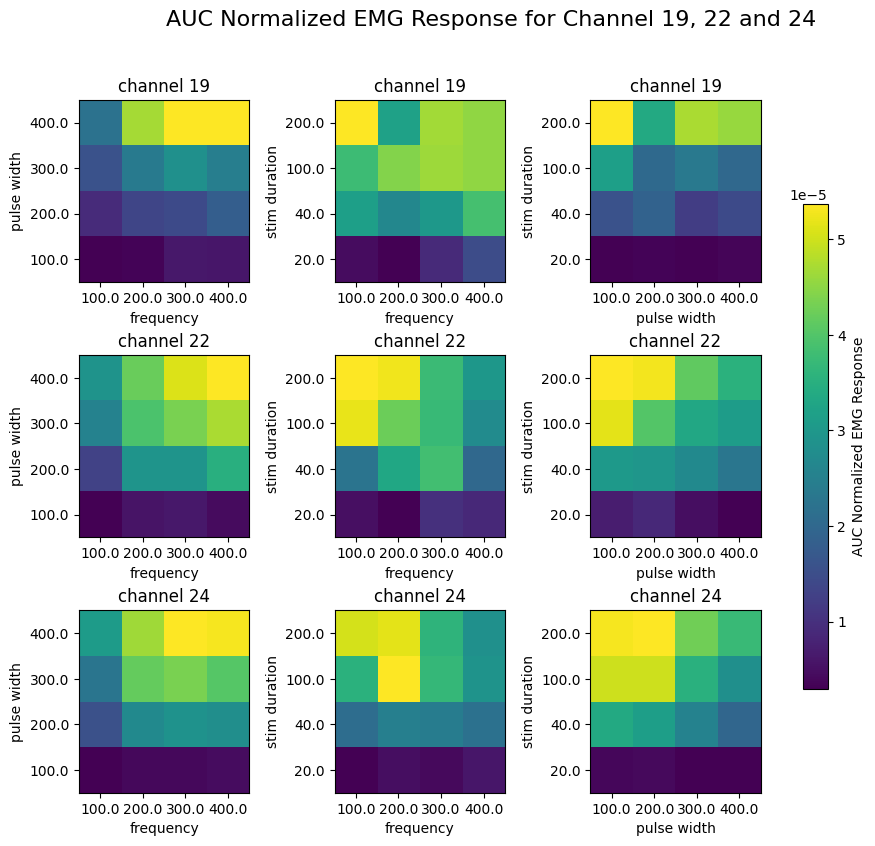

In [112]:
visualize_heatmaps(auc_norm_map, 'AUC Normalized EMG Response')

### Overall change in responses

In [114]:
val_p0 = np.unique(param[:,0])
val_p1 = np.unique(param[:,1])
val_p2 = np.unique(param[:,2])
val_ch = np.unique(param[:,4])

In [115]:
def exp_plot_pw_dur(emg_ch, mean_map, f = 3):
    
    print('EMG channel selected: '+ str(emg_ch))

    fig, ax = plt.subplots(3,4)
    vmin = np.min(mean_map[emg_ch, :, f, :, :, :])
    vmax = np.max(mean_map[emg_ch, :, f, :, :, :])
    
    for i in range(3):
        
        for j in range(4):
        
            ax[i,j].imshow(mean_map[emg_ch, j, f, i, :, :], vmin=vmin, vmax=vmax)
            #ax[i,j].set_title('PW = '+str(int(np.round(val_p0[i]))))
            
    plt.tight_layout()


In [116]:
def exp_plot(emg_ch, mean_map, pw = 3 , f = 3, dur = 0):
    
    print('EMG channel selected: '+ str(emg_ch))

    fig, ax = plt.subplots(1,4, figsize=(10,3))
    vmin = np.min(mean_map[emg_ch, :, f, dur, :, :])
    vmax = np.max(mean_map[emg_ch, :, f, dur, :, :])
    for i in range(4):
        ax[i].imshow(mean_map[emg_ch, i, f, dur, :, :], vmin=vmin, vmax=vmax)
        ax[i].set_title('PW = '+str(int(np.round(val_p0[i]))))

    fig, ax = plt.subplots(1,4, figsize=(10,3))
    vmin = np.min(mean_map[emg_ch, pw, :, dur, :, :])
    vmax = np.max(mean_map[emg_ch, pw, :, dur, :, :])
    for i in range(4):
        ax[i].imshow(mean_map[emg_ch, pw, i, dur, :, :], vmin=vmin, vmax=vmax)
        ax[i].set_title('freq = '+str(int(np.round(val_p1[i]))))

    fig, ax = plt.subplots(1,4, figsize=(10,3))
    vmin = np.min(mean_map[emg_ch, pw, f, :, :, :])
    vmax = np.max(mean_map[emg_ch, pw, f, :, :, :])
    for i in range(4):
        ax[i].imshow(mean_map[emg_ch, pw, f, i, :, :], vmin=vmin, vmax=vmax)
        ax[i].set_title('dur. = '+str(int(np.round(val_p2[i]))))

In [117]:
sampled_indices = np.random.choice(resp.shape[0], size=6, replace=False)

# Extract the sampled dimensions
sampled_resp = resp[sampled_indices, :, :]

sampled_mean_map = create_mean_map(sampled_resp)

EMG channel selected: 0


IndexError: index 3 is out of bounds for axis 0 with size 3

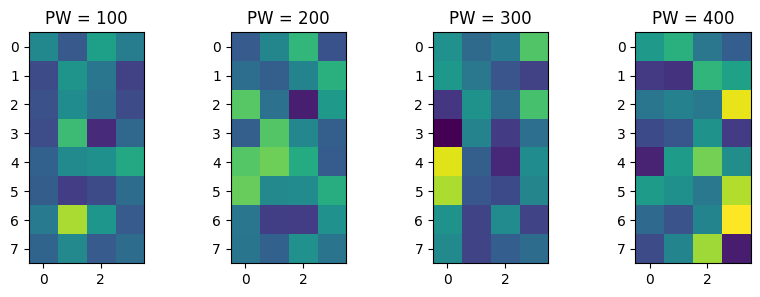

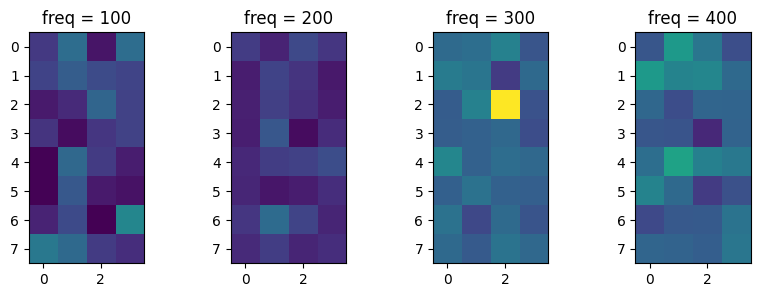

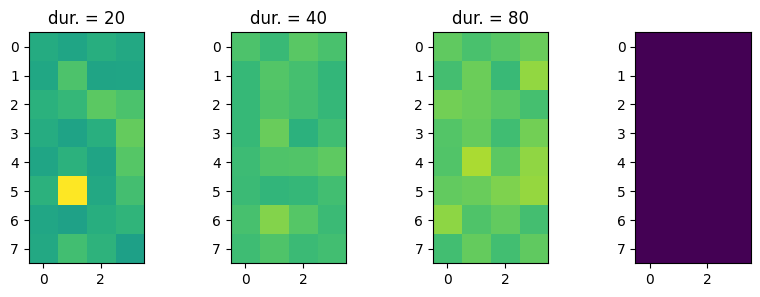

In [118]:
emg_ch =0
exp_plot(emg_ch, sampled_mean_map, dur = 1, pw = 0, f = 1)

In [64]:
sampled_indices = np.random.choice(resp.shape[0], size=6, replace=False)

# Extract the sampled dimensions
sampled_resp = resp[sampled_indices, :, :]

sampled_mean_map = create_mean_map(sampled_resp)

EMG channel selected: 0


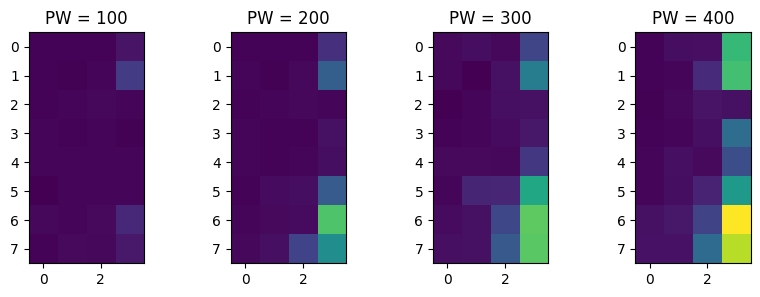

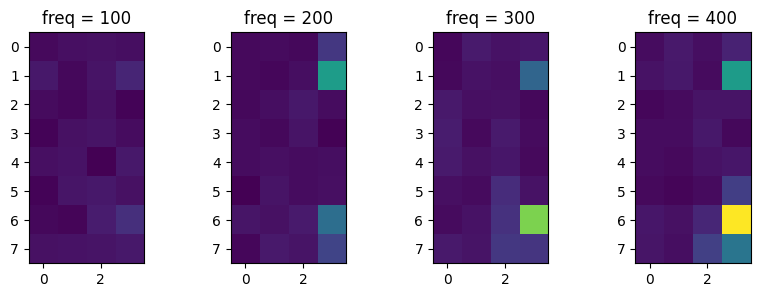

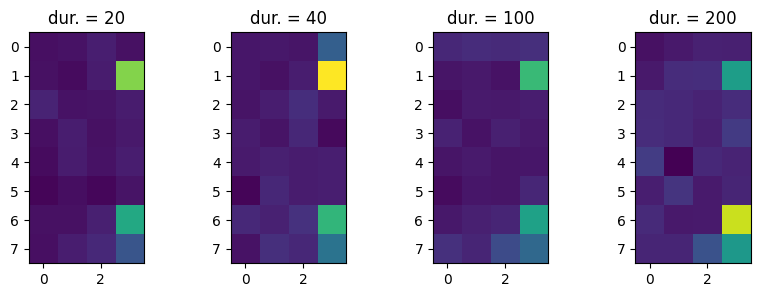

In [65]:
emg_ch =0
exp_plot(emg_ch, sampled_mean_map, dur = 1, pw = 0, f = 1)

### Peak response for channel 24

In [75]:
peak_map = create_mean_map(peak_resp)

In [76]:
peak_map.shape

(4, 4, 4, 4, 8, 4)

In [77]:
channel_24_resp = peak_map[emg_channel, other_stim_param_idx, :, :, 7, 3]
channel_24_resp.shape

(4, 4)

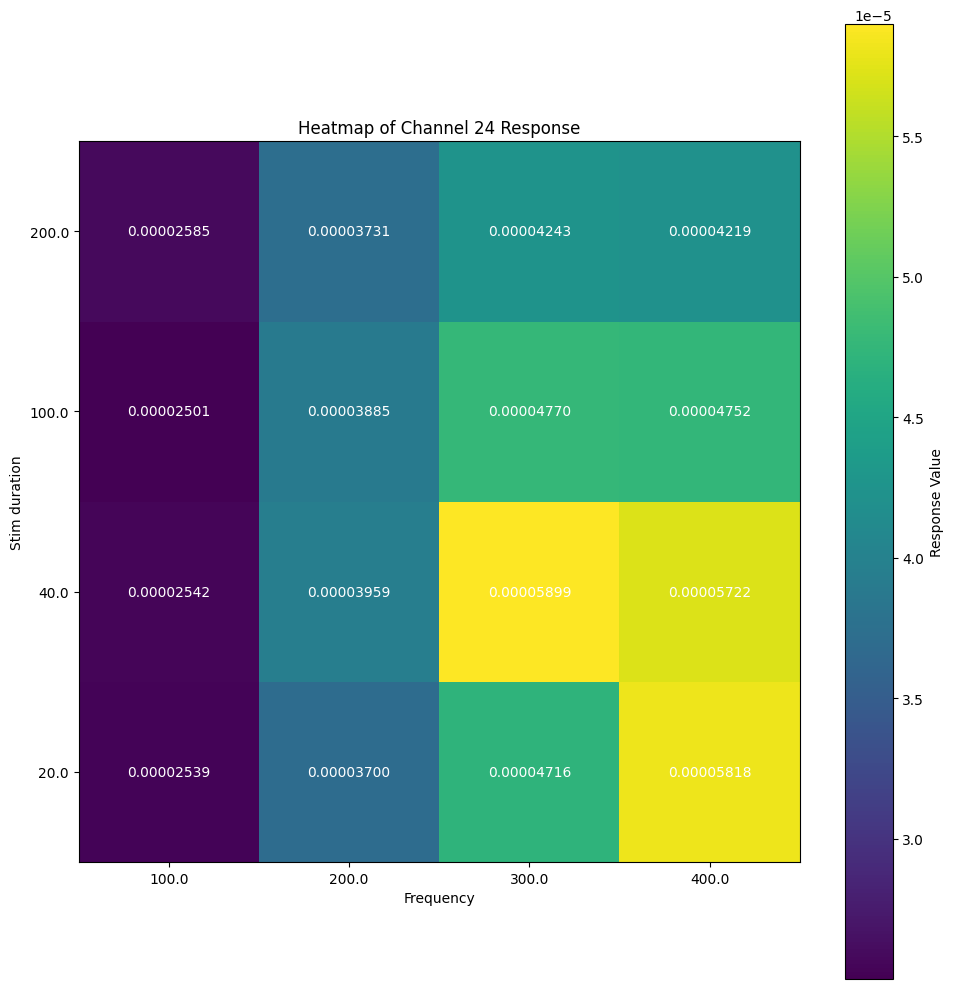

In [99]:
# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size if needed
heatmap = ax.imshow(channel_24_resp.T, cmap='viridis', origin='lower')

x = np.round(np.unique(param[:, 0]))
y = np.round(np.unique(param[:, 2]))

# Add colorbar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Response Value')  # Label for colorbar

# Annotate each cell with its value
for i in range(channel_24_resp.shape[0]):
    for j in range(channel_24_resp.shape[1]):
        ax.text(j, i, f'{channel_24_resp.T[i, j]:.8f}', ha='center', va='center', color='white')

# Set labels and ticks
ax.set_title('Heatmap of Channel 24 Response')
ax.set_xlabel('Frequency')
ax.set_ylabel('Stim duration')
ax.set_xticks(ticks=np.arange(len(x)), labels=x)
ax.set_yticks(ticks=np.arange(len(y)), labels=y)

# Show the plot
plt.tight_layout()
plt.show()

### AUC response for channel 24

In [93]:
auc_map = create_mean_map(auc_resp)

In [94]:
channel_24_resp = auc_map[emg_channel, other_stim_param_idx, :, :, 7, 3]
channel_24_resp.shape

(4, 4)

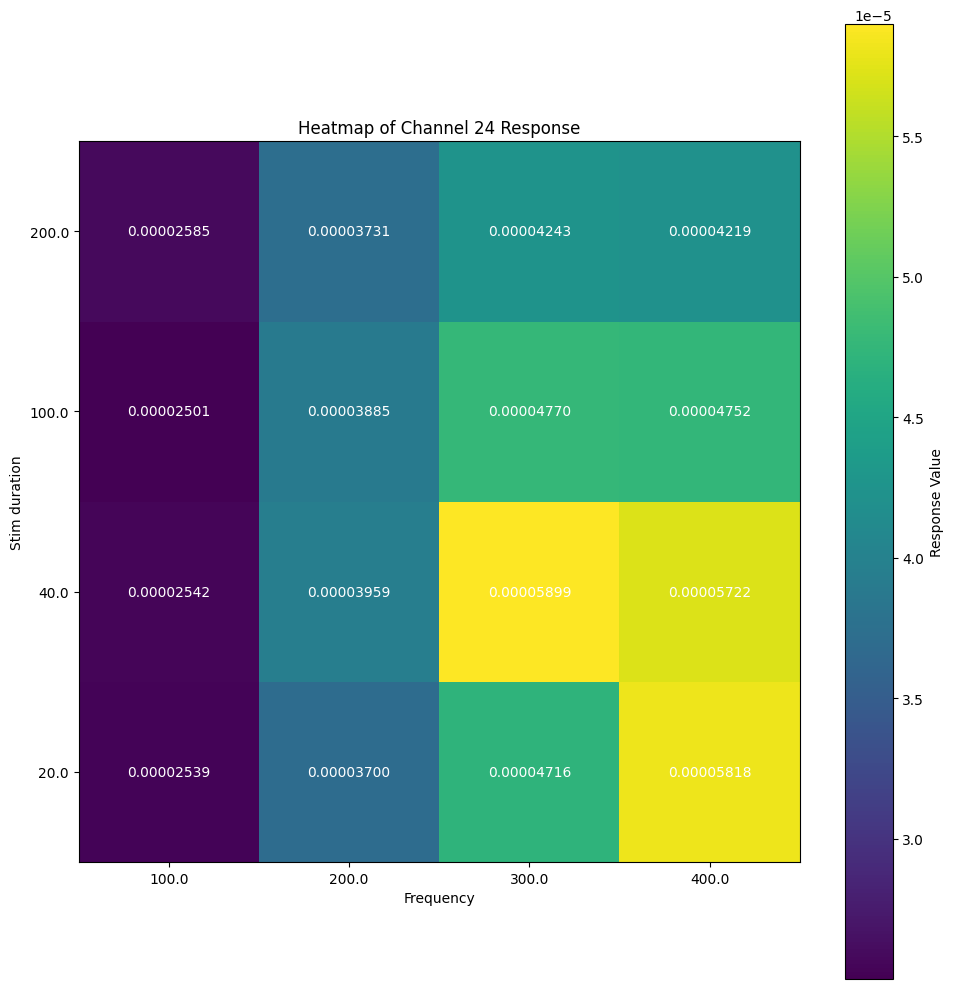

In [95]:
# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size if needed
heatmap = ax.imshow(channel_24_resp.T, cmap='viridis', origin='lower')

x = np.round(np.unique(param[:, 0]))
y = np.round(np.unique(param[:, 2]))

# Add colorbar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Response Value')  # Label for colorbar

# Annotate each cell with its value
for i in range(channel_24_resp.shape[0]):
    for j in range(channel_24_resp.shape[1]):
        ax.text(j, i, f'{channel_24_resp.T[i, j]:.8f}', ha='center', va='center', color='white')

# Set labels and ticks
ax.set_title('Heatmap of Channel 24 Response')
ax.set_xlabel('Frequency')
ax.set_ylabel('Stim duration')
ax.set_xticks(ticks=np.arange(len(x)), labels=x)
ax.set_yticks(ticks=np.arange(len(y)), labels=y)

# Show the plot
plt.tight_layout()
plt.show()

### AUC channel 19

In [96]:
auc_map = create_mean_map(auc_resp)

In [97]:
channel_19_resp = auc_map[emg_channel, other_stim_param_idx, :, :, 1, 3]
channel_19_resp.shape

(4, 4)

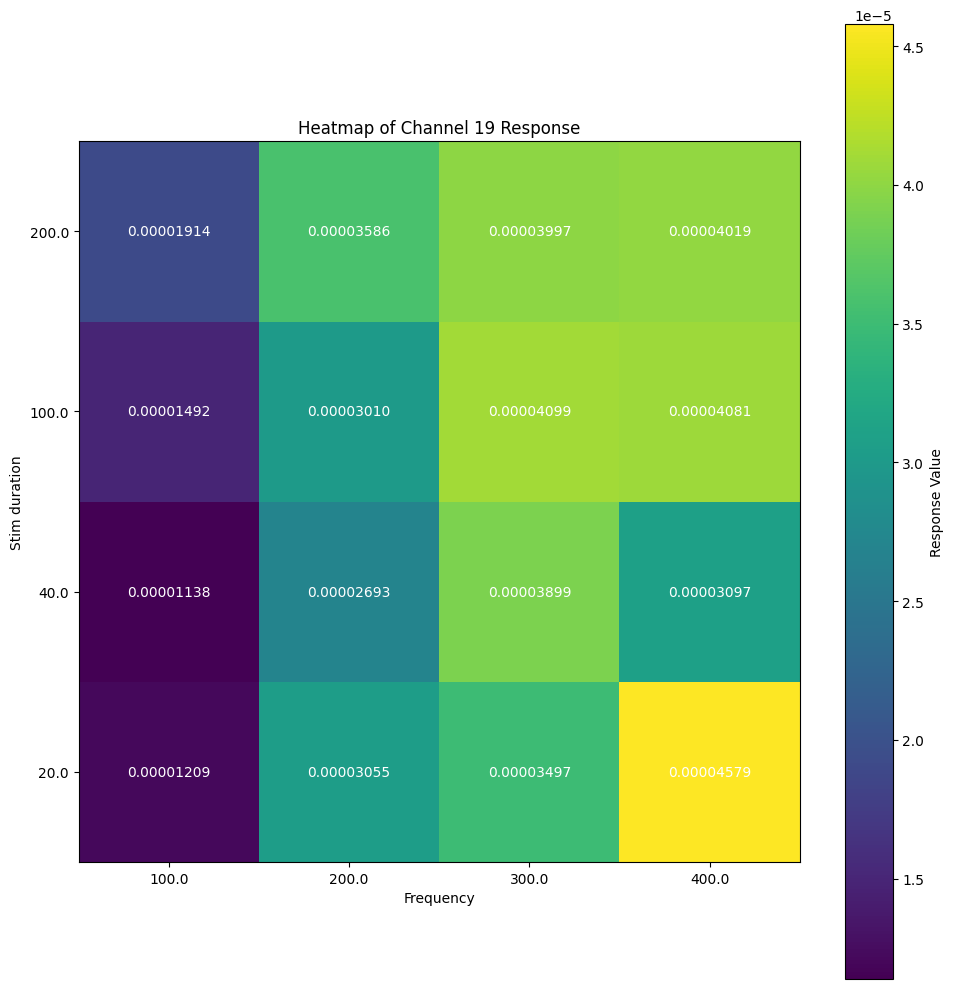

In [98]:
# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size if needed

heatmap = ax.imshow(channel_19_resp.T, cmap='viridis', origin='lower')

x = np.round(np.unique(param[:, 0]))
y = np.round(np.unique(param[:, 2]))

# Add colorbar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Response Value')  # Label for colorbar

# Annotate each cell with its value
for i in range(channel_19_resp.shape[0]):
    for j in range(channel_19_resp.shape[1]):
        ax.text(j, i, f'{channel_19_resp.T[i, j]:.8f}', ha='center', va='center', color='white')

# Set labels and ticks
ax.set_title('Heatmap of Channel 19 Response')
ax.set_xlabel('Frequency')
ax.set_ylabel('Stim duration')
ax.set_xticks(ticks=np.arange(len(x)), labels=x)
ax.set_yticks(ticks=np.arange(len(y)), labels=y)

# Show the plot
plt.tight_layout()
plt.show()